In [1]:
from keras.models import Model, Sequential, model_from_json,load_model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.preprocessing.image import load_img, save_img, img_to_array,ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import History, EarlyStopping
import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from scipy.misc import imresize
import os
import PIL
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

Using TensorFlow backend.


In [2]:
def instantiate_model(i,num_dense = 120):
    """Instantiates the VGG Facial recognition model. 
    Removes the last layer from pre-trained model.
    Adds a new Dense() layer with num_dense nodes.
    Adds a final Dense(2) layer.
    Sets the last i layers as trainable, and fixes the others. """
    
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    model.load_weights('vgg_face_weights.h5')
    
    hidden = Dense(num_dense, activation='relu')(model.layers[-2].output)
    out = Dense(2, activation='softmax')(hidden)
    model2 = Model(input=model.layers[0].input, output=out)
    model = model2
    layer_count = 0
    for layer in model.layers:
        layer_count = layer_count+1
    print(layer_count)
    for l in range(layer_count):
        model.layers[l].trainable=True
    for l in range(layer_count-i):
        model.layers[l].trainable=False

    return model

In [5]:
def create_collage2(badAJ, badPJ,widthin=600,heightin=300,cols=5,rows=5):    
    for zz in [0,1]:
        if zz == 0:
            bads = badPJ
        else:
            bads = badAJ
        lenP = len(bads)
        if lenP < 1:
            continue
        cols = min(5,lenP)               #round(lenP/2)
        rows = max(1,lenP//cols)  #round(lenP/cols)
        width = int(widthin / 5*cols)
        height = int(rows*(width/cols))
        #print(cols,rows,width,height)        
        thumbnail_width = width//cols
        thumbnail_height = height//rows
        size = thumbnail_width, thumbnail_height
        new_im = Image.new('RGB', (width, height))
        ims = []  
        for p in bads:
            im = Image.fromarray(np.uint8(p))
            im.thumbnail(size)
            ims.append(im)
        i,x,y = 0,0,0
        for col in range(cols):
            for row in range(rows):
                #print(i, x, y)
                tmp = ims[i]
                new_im.paste(tmp, (x, y))
                i += 1
                y += thumbnail_height
            x += thumbnail_width
            y = 0

        if zz == 0:
            print('Thinks Paul is Anthony ====== ')
        else:
            print('Thinks Anthony is Paul ====== ')
        plot_image(new_im)

In [6]:
def create_collage(width, height, path,name,collage_file,numimages,ims_in):
    print('Collage for ',name,' from ',path)
    widthin = 600
    cols = min(14,numimages)               
    rows = int(np.ceil(numimages/14)) 
    width = int(widthin / 14*cols)
    height = int((rows)*(width/cols))
    thumbnail_width = width//cols
    thumbnail_height = height//rows
    size = thumbnail_width, thumbnail_height
    new_im = Image.new('RGB', (width, height))
    ims = []
    #listofimages = os.listdir(path+ name)    
    for p in ims_in:
        #print(path + name + '/' + p)
        #if p == '.DS_Store':
        #    continue
        #im = Image.open(path + name + '/' + p)
        im = Image.fromarray(np.uint8(p))
        im.thumbnail(size)
        ims.append(im)
    i = 0
    x = 0
    y = 0
    for col in range(cols):
        for row in range(rows):
            #print(i, x, y)
            try:
                tmp = ims[i]
            except:
                break
            new_im.paste(tmp, (x, y))
            i += 1
            y += thumbnail_height
        x += thumbnail_width
        y = 0

    new_im.save(collage_file)
    plot_image(new_im)

In [7]:
def plot_image(image):
    """Displays image"""
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    display(PIL.Image.fromarray(image))
    
def resize_im(im,sq):
    """Resize image to 224x224"""
    #print(im.shape)
    try:
        width,height,col = im.shape
    except:
        col = 3
        width,height = im.shape
        im = [im,im,im]
    assert width == height    
    if width != sq:
        im_out = imresize(im, (sq,sq,col), interp='bilinear', mode=None)
        #im_out = resize(im, (sq,sq,col))
    else:
        im_out = im
    return im_out

def getXY(path,sq=224):
    """Gets the images from path, for AJ and PJ.
    Returns X and Y to be fit to model.
    X is ndarray = (# images) x 224 x 224 x 3
    Y is ndarray = (# images) x 2 """
    
    path_to_dataPJ = path + 'PJ/'
    path_to_dataAJ = path + 'AJ/'
    PJfiles = os.listdir(path_to_dataPJ)
    AJfiles = os.listdir(path_to_dataAJ)
    trainy = []
    num_images = 0
    for i in range(len(PJfiles)):
        if PJfiles[i] == '.DS_Store':
            continue
        num_images += 1
    for i in range(len(AJfiles)):
        if AJfiles[i] == '.DS_Store':
            continue
        num_images += 1
    print(path,' Number of images: ',num_images)
    trainX = np.ndarray([num_images,sq,sq,3])
    counter=0
    for i in range(len(PJfiles)):        
        tmp_file = path_to_dataPJ + PJfiles[i]
        if PJfiles[i] == '.DS_Store':
            continue
        #print(tmp_file)
        tmp = imread(tmp_file)      
        tmp2 = resize_im(tmp,sq)
        trainX[counter,:,:,:] = tmp2[:,:,:3]
        counter += 1
        trainy.append(1)

    for i in range(len(AJfiles)):        
        tmp_file = path_to_dataAJ + AJfiles[i]
        if AJfiles[i] == '.DS_Store':
            continue
        tmp = imread(tmp_file)
        tmp2 = resize_im(tmp,sq)
        trainX[counter,:,:,:] = tmp2[:,:,:3]
        counter += 1
        trainy.append(0)
        
    Y = to_categorical(trainy)
    X = trainX.reshape(num_images,sq,sq,3)
    print('Done importing ',str(num_images),' images from ... ',path)
    return X, Y,int(num_images/2)
def show_errors(predY, trueY,X,which):
    cm = confusion_matrix(trueY,predY)
    print(which, ' =====================')
    print(cm)
    c = 0
    names = ['Anthony','Paul']
    badimsAJ = []
    badimsPJ = []
    for i,j in list(zip(predY,trueY)):
        k = i-j
        if k != 0:
            #print('Mistake! Thinks ',names[trueY[c]],' is ',names[predY[c]])
            if j == 1: # is actually Paul
                badimsPJ.append(X[c])
            else:
                badimsAJ.append(X[c])
            #plot_image(X[c])
        c += 1  
    create_collage2(badimsAJ,badimsPJ)
    
def plot_history(history):
    """Plot history of training of input model history"""
    #plt.subplot(2,1,1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
    ax1.plot(history.history['acc'])#,color='r')
    ax1.plot(history.history['val_acc'])#,color='k')
    #plt.plot(history.history['val_acc'])
    #ax1.title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')
    #ax1.show()
    # summarize history for loss
    #ax2.subplot(2,1,2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    #ax2.title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    #ax2.show()
    plt.show()

In [8]:
path_training = 'Training2/'
path_testing = 'Testing/'
trainX, trainY,numtrain = getXY(path_training)
testX, testY,numtest = getXY(path_testing)    

Training2/  Number of images:  236


/Users/Anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Done importing  236  images from ...  Training2/
Testing/  Number of images:  54
Done importing  54  images from ...  Testing/


Collage for  AJ  from  Training2/


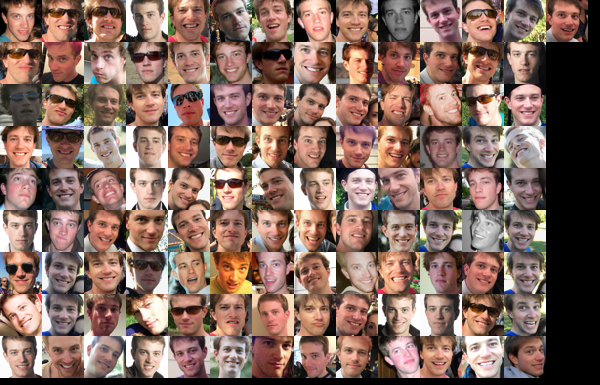

Collage for  PJ  from  Training2/


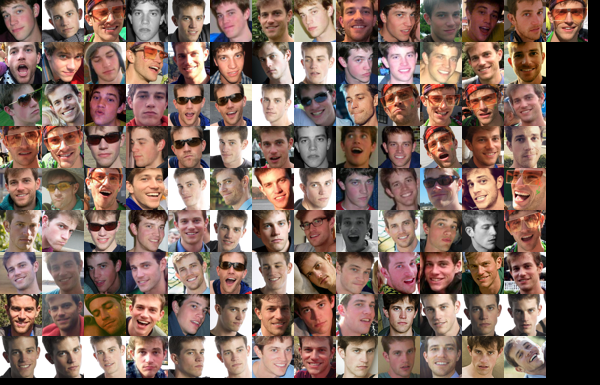

Collage for  AJ  from  Testing/


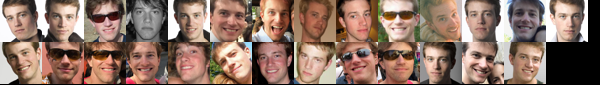

Collage for  PJ  from  Testing/


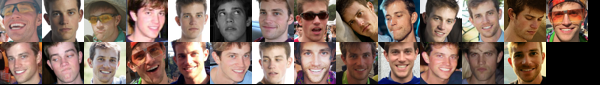

In [9]:
create_collage(700, 500, path_training , 'AJ', 'collage.jpg',numtrain,trainX[numtrain:,:,:,:])
create_collage(700, 500, path_training , 'PJ', 'collage.jpg',numtrain,trainX[0:numtrain,:,:,:])
create_collage(450, 300, path_testing, 'AJ', 'collage.jpg',numtest,testX[numtest:,:,:,:])
create_collage(450, 300, path_testing , 'PJ', 'collage.jpg',numtest,testX[0:numtest,:,:,:])

SGD/twinmodel4.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/Users/Anthony/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


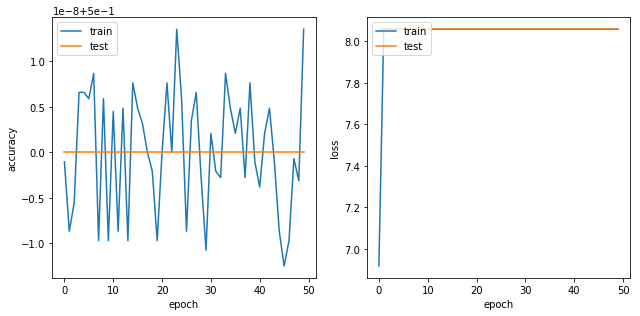

ValueError: Found input variables with inconsistent numbers of samples: [236, 172]

In [9]:
# Try setting more or less layers to untrainable. 
# These runs had trouble converging
this_folder = 'SGD/'
if not os.path.exists(this_folder):
    os.makedirs(this_folder)
for i in [4,5,6,7,8,9]:
    file_save = this_folder + 'twinmodel' + str(i) + '.h5'
    pckl_save_hist = this_folder + 'twinmodel'+str(i)+'hist.h5'
    pckl_save = this_folder + 'twinmodel_pred' + str(i) + '.pckl'
    print(file_save)
    if os.path.isfile(file_save) == False:
        model = instantiate_model(i)
        #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        model.compile(optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),
                      loss='categorical_crossentropy',metrics=['accuracy'])
        #history = model.fit(trainX, trainY, batch_size=50, epochs=50)  
        history = model.fit(trainX, trainY, batch_size=50, epochs=50,shuffle=True,validation_data=(testX, testY))
                
        model.save(file_save)        
        tmp = open(pckl_save_hist, 'wb')
        pickle.dump([history], tmp)
        tmp.close()
    else:
        model = load_model(file_save)
        #try:
        tmp = open(pckl_save_hist, 'rb')
        history = pickle.load(tmp)
        tmp.close()   
        #except:
        #    pass
    
    if os.path.isfile(pckl_save) == False: 
        test_predY = model.predict(testX[:])[:,1]
        train_predY = model.predict(trainX[:])[:,1]
        tmp = open(pckl_save, 'wb')
        pickle.dump([test_predY,train_predY], tmp)
        tmp.close()
    else:
        tmp = open(pckl_save, 'rb')
        [test_predY,train_predY] = pickle.load(tmp)
        tmp.close()  
        
    try:
        plot_history(history[0])
    except:
        pass
    test_predY2 = test_predY.round().astype(int)
    testY2 = testY[:,1].round().astype(int)
    train_predY2 = train_predY.round().astype(int)
    trainY2 = trainY[:,1].round().astype(int)
    score_train = accuracy_score(trainY2,train_predY2)
    score_test = accuracy_score(testY2,test_predY2)
    print('Training score: ',score_train, ' , Testing score:',score_test)
    #show_errors(train_predY2,trainY2,trainX)

Experiment3/twinmodel3_0.001_10.h5 , i:  3 , lr:  0.001  num_dense:  10


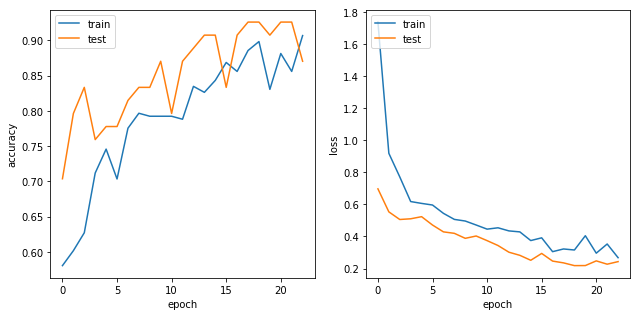

Training score:  0.9449152542372882  , Testing score: 0.8703703703703703
Training  =====================
[[116   2]
 [ 11 107]]
Thinks Paul is Anthony ====== 


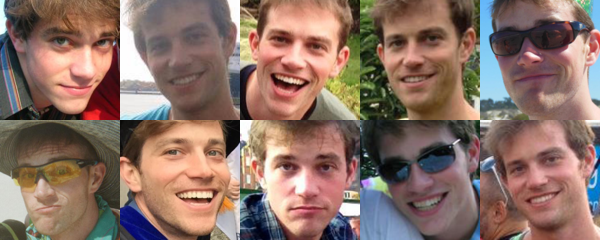

Thinks Anthony is Paul ====== 


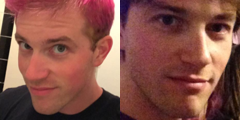

Testing  =====================
[[24  3]
 [ 4 23]]
Thinks Paul is Anthony ====== 


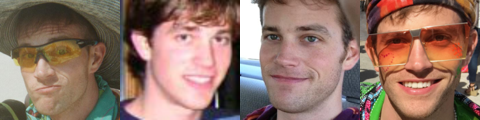

Thinks Anthony is Paul ====== 


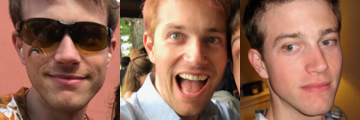

Experiment3/twinmodel3_0.001_50.h5 , i:  3 , lr:  0.001  num_dense:  50


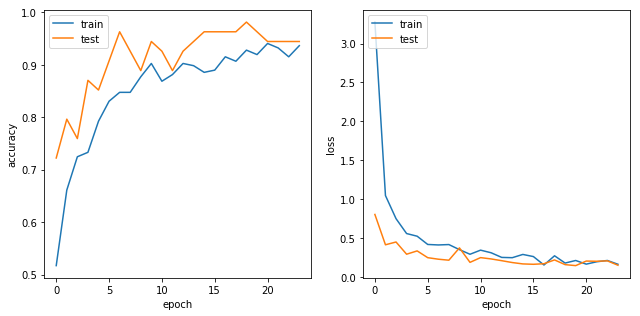

Training score:  0.9788135593220338  , Testing score: 0.9444444444444444
Training  =====================
[[117   1]
 [  4 114]]
Thinks Paul is Anthony ====== 


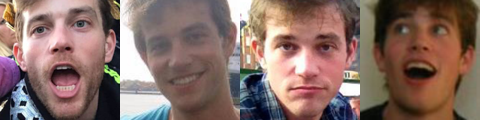

Thinks Anthony is Paul ====== 


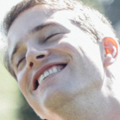

Testing  =====================
[[25  2]
 [ 1 26]]
Thinks Paul is Anthony ====== 


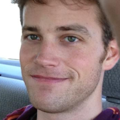

Thinks Anthony is Paul ====== 


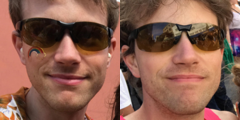

Experiment3/twinmodel3_0.001_100.h5 , i:  3 , lr:  0.001  num_dense:  100


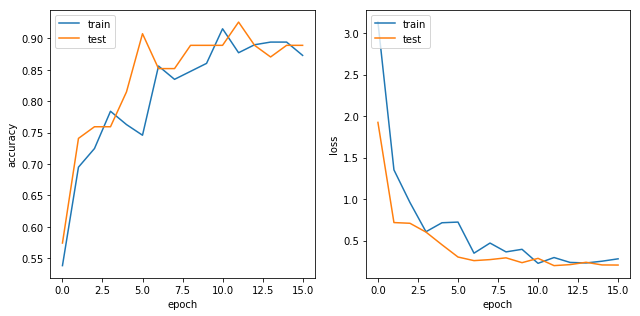

Training score:  0.9703389830508474  , Testing score: 0.8888888888888888
Training  =====================
[[118   0]
 [  7 111]]
Thinks Paul is Anthony ====== 


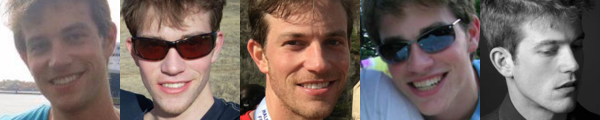

Testing  =====================
[[25  2]
 [ 4 23]]
Thinks Paul is Anthony ====== 


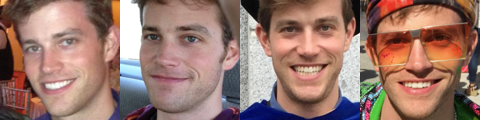

Thinks Anthony is Paul ====== 


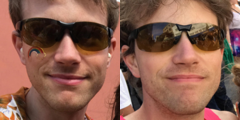

Experiment3/twinmodel3_0.001_200.h5 , i:  3 , lr:  0.001  num_dense:  200


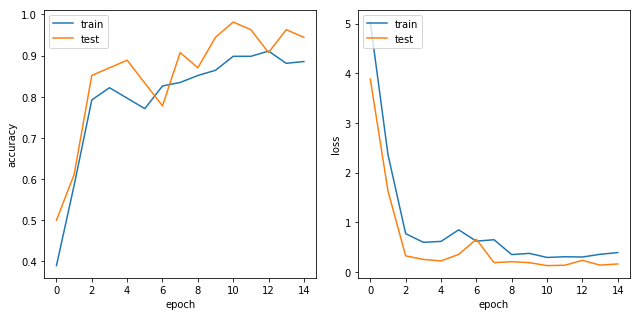

Training score:  0.9788135593220338  , Testing score: 0.9444444444444444
Training  =====================
[[114   4]
 [  1 117]]
Thinks Paul is Anthony ====== 


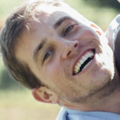

Thinks Anthony is Paul ====== 


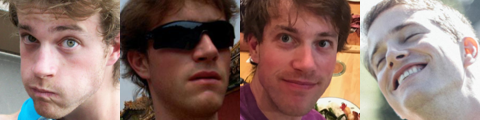

Testing  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


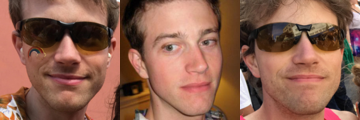

Experiment3/twinmodel4_0.001_10.h5 , i:  4 , lr:  0.001  num_dense:  10


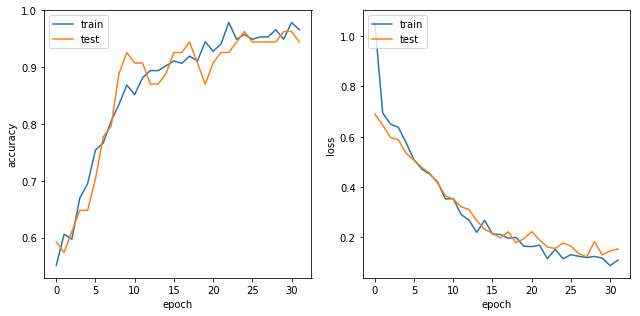

Training score:  0.9915254237288136  , Testing score: 0.9444444444444444
Training  =====================
[[116   2]
 [  0 118]]
Thinks Anthony is Paul ====== 


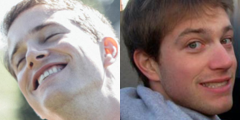

Testing  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


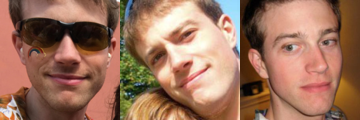

Experiment3/twinmodel4_0.001_50.h5 , i:  4 , lr:  0.001  num_dense:  50


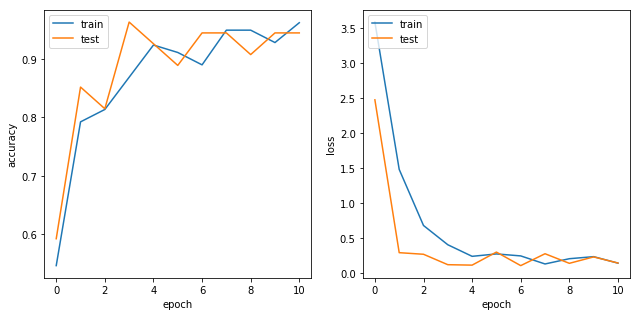

Training score:  1.0  , Testing score: 0.9444444444444444
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


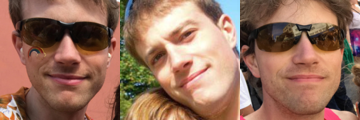

Experiment3/twinmodel4_0.001_100.h5 , i:  4 , lr:  0.001  num_dense:  100


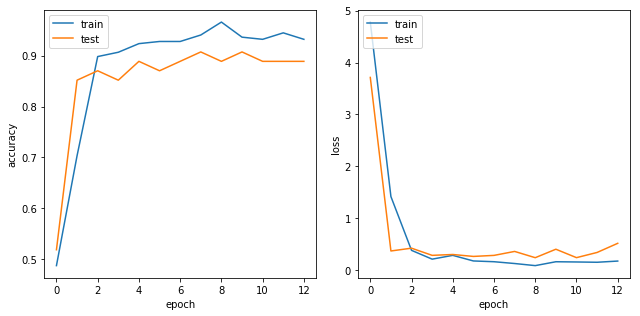

Training score:  0.9872881355932204  , Testing score: 0.8888888888888888
Training  =====================
[[115   3]
 [  0 118]]
Thinks Anthony is Paul ====== 


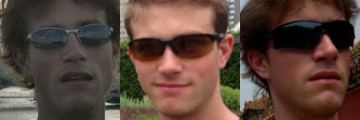

Testing  =====================
[[21  6]
 [ 0 27]]
Thinks Anthony is Paul ====== 


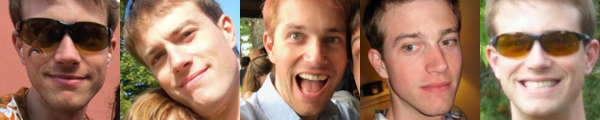

Experiment3/twinmodel4_0.001_200.h5 , i:  4 , lr:  0.001  num_dense:  200


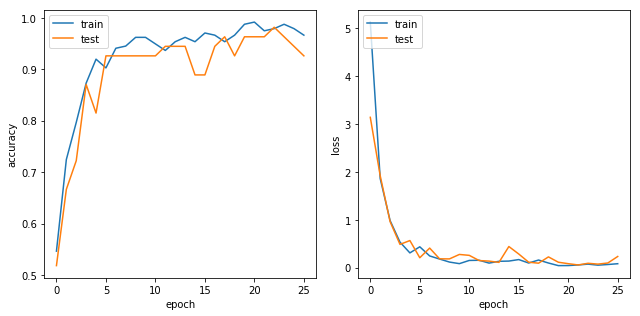

Training score:  1.0  , Testing score: 0.9259259259259259
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


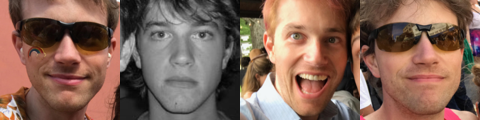

Experiment3/twinmodel5_0.001_10.h5 , i:  5 , lr:  0.001  num_dense:  10


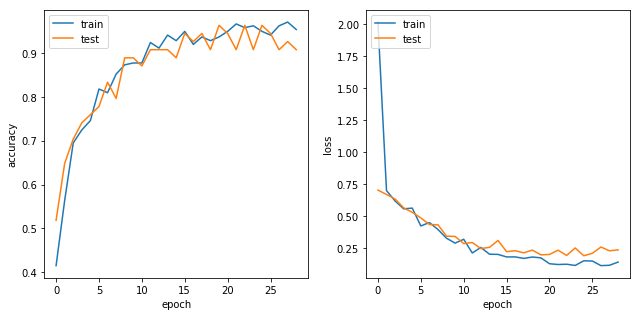

Training score:  0.9957627118644068  , Testing score: 0.9074074074074074
Training  =====================
[[117   1]
 [  0 118]]
Thinks Anthony is Paul ====== 


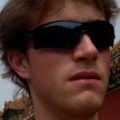

Testing  =====================
[[22  5]
 [ 0 27]]
Thinks Anthony is Paul ====== 


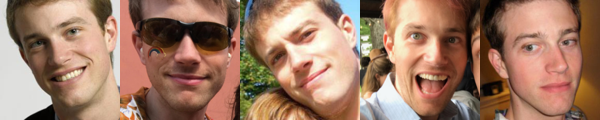

Experiment3/twinmodel5_0.001_50.h5 , i:  5 , lr:  0.001  num_dense:  50


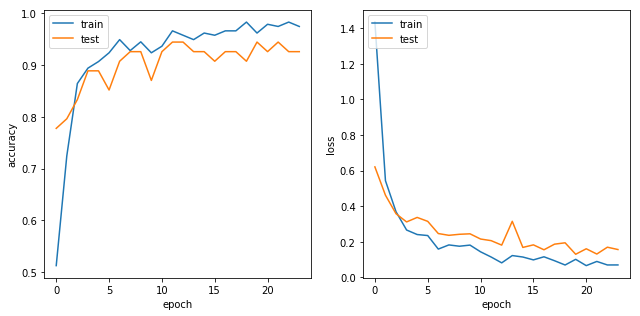

Training score:  1.0  , Testing score: 0.9259259259259259
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[24  3]
 [ 1 26]]
Thinks Paul is Anthony ====== 


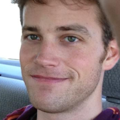

Thinks Anthony is Paul ====== 


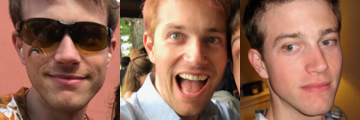

Experiment3/twinmodel5_0.001_100.h5 , i:  5 , lr:  0.001  num_dense:  100


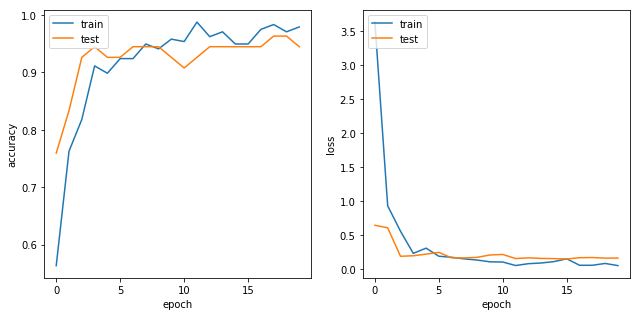

Training score:  1.0  , Testing score: 0.9444444444444444
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[25  2]
 [ 1 26]]
Thinks Paul is Anthony ====== 


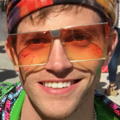

Thinks Anthony is Paul ====== 


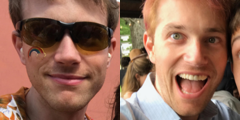

Experiment3/twinmodel5_0.001_200.h5 , i:  5 , lr:  0.001  num_dense:  200


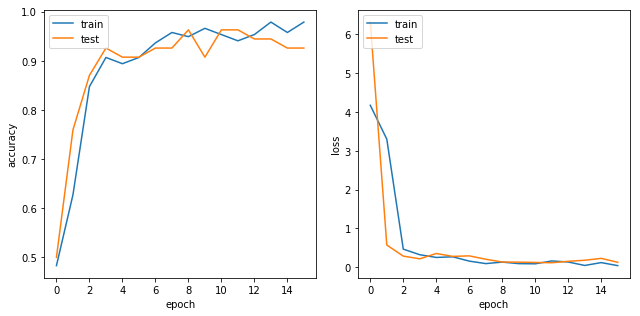

Training score:  1.0  , Testing score: 0.9259259259259259
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


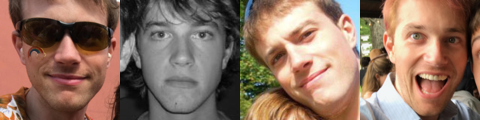

Experiment3/twinmodel6_0.001_10.h5 , i:  6 , lr:  0.001  num_dense:  10


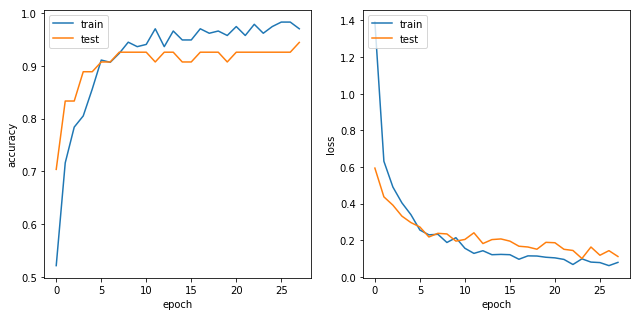

Training score:  1.0  , Testing score: 0.9444444444444444
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


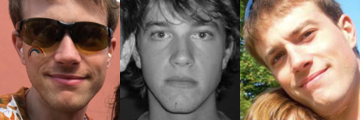

Experiment3/twinmodel6_0.001_50.h5 , i:  6 , lr:  0.001  num_dense:  50


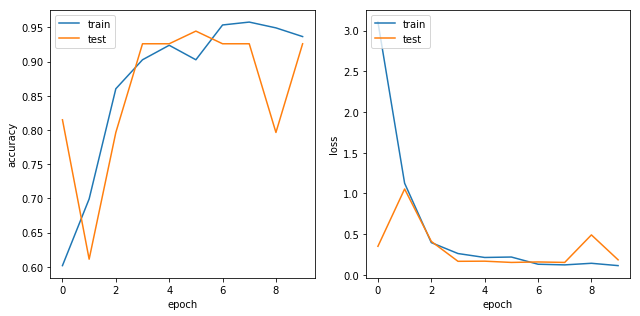

Training score:  0.9957627118644068  , Testing score: 0.9259259259259259
Training  =====================
[[117   1]
 [  0 118]]
Thinks Anthony is Paul ====== 


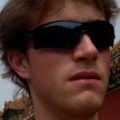

Testing  =====================
[[24  3]
 [ 1 26]]
Thinks Paul is Anthony ====== 


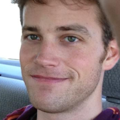

Thinks Anthony is Paul ====== 


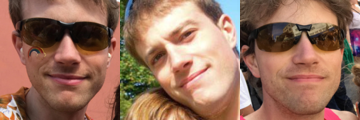

Experiment3/twinmodel6_0.001_100.h5 , i:  6 , lr:  0.001  num_dense:  100


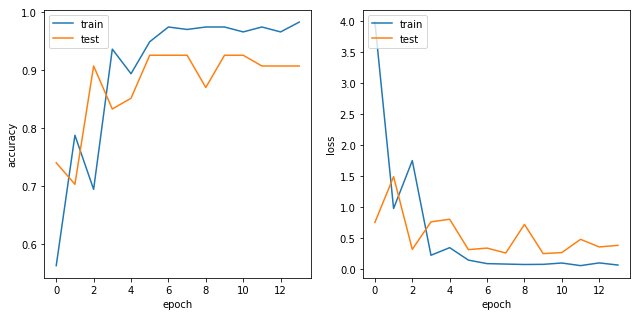

Training score:  1.0  , Testing score: 0.9074074074074074
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[22  5]
 [ 0 27]]
Thinks Anthony is Paul ====== 


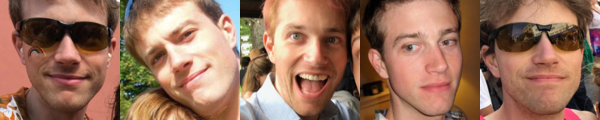

Experiment3/twinmodel6_0.001_200.h5 , i:  6 , lr:  0.001  num_dense:  200


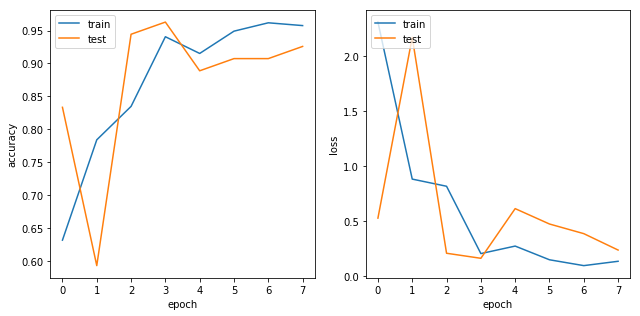

Training score:  0.9957627118644068  , Testing score: 0.9259259259259259
Training  =====================
[[118   0]
 [  1 117]]
Thinks Paul is Anthony ====== 


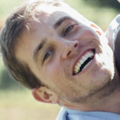

Testing  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


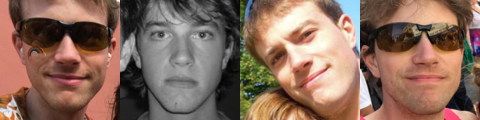

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')
this_folder = 'Experiment3/'
if not os.path.exists(this_folder):
    os.makedirs(this_folder)
for i in [3,4,5,6]:
    for lr in [.001]:
        for num_dense in [10,50,100,200]:
            file_save = this_folder + 'twinmodel' + str(i) + '_' + str(lr) + '_' + str(num_dense) + '.h5'
            pckl_save_hist = this_folder + 'twinmodel'+str(i)+ '_' + str(lr) + '_' + str(num_dense)+'hist.pckl'
            pckl_save = this_folder + 'twinmodel_pred' + str(i)+ '_' + str(lr) + '_' + str(num_dense) + '.pckl'
            print(file_save,', i: ',i,', lr: ',lr,' num_dense: ',num_dense )
            if os.path.isfile(file_save) == False:
                history = History()
                model = instantiate_model(i,num_dense=num_dense)
                #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
                model.compile(optimizer=keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.00, nesterov=False),
                              loss='categorical_crossentropy',metrics=['accuracy'])
                #history = model.fit(trainX, trainY, batch_size=50, epochs=50)  
                model.fit(trainX, trainY, batch_size=50, epochs=50,
                                    shuffle=True,validation_data=(testX, testY), callbacks=[history,early_stopping])

                model.save(file_save)        
                #tmp = open(pckl_save_hist, 'wb')
                with open(pckl_save_hist, 'wb') as tmp:
                    pickle.dump([history], tmp)
                #tmp.close()
            else:
                model = load_model(file_save)
                #try:
                #tmp = open(pckl_save_hist, 'rb')
                #history = pickle.load(tmp)
                #tmp.close()   
                with open(pckl_save_hist, 'rb') as tmp:
                    history = pickle.load(tmp)

            if os.path.isfile(pckl_save) == False: 
                test_predY = model.predict(testX[:])[:,1]
                train_predY = model.predict(trainX[:])[:,1]
                #tmp = open(pckl_save, 'wb')
                with open(pckl_save, 'wb') as tmp:
                    pickle.dump([test_predY,train_predY], tmp)
                #tmp.close()
            else:
                #tmp = open(pckl_save, 'rb')
                with open(pckl_save, 'rb') as tmp:
                    [test_predY,train_predY] = pickle.load(tmp)
                #tmp.close()  

            plot_history(history[0])
                
            test_predY2 = test_predY.round().astype(int)
            testY2 = testY[:,1].round().astype(int)
            train_predY2 = train_predY.round().astype(int)
            trainY2 = trainY[:,1].round().astype(int)
            score_train = accuracy_score(trainY2,train_predY2)
            score_test = accuracy_score(testY2,test_predY2)
            print('Training score: ',score_train, ' , Testing score:',score_test)
            show_errors(train_predY2,trainY2,trainX,'Training')
            show_errors(test_predY2,testY2,testX,'Testing')

In [25]:
# Load best model so far
bestfile = 'Experiment3/'
#bestfile = ''
file_save = bestfile+'twinmodel5_0.001_100.h5'
model = load_model(file_save)
pckl_save = bestfile+'twinmodel_pred5_0.001_100.pckl'
tmp = open(pckl_save, 'rb')
[test_predY,train_predY] = pickle.load(tmp)
tmp.close()  

Training score:  1.0  , Testing score: 0.9444444444444444
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[25  2]
 [ 1 26]]
Thinks Paul is Anthony ====== 


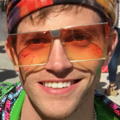

Thinks Anthony is Paul ====== 


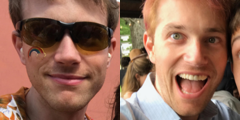

In [35]:
test_predY2 = test_predY.round().astype(int)
testY2 = testY[:,1].round().astype(int)
train_predY2 = train_predY.round().astype(int)
trainY2 = trainY[:,1].round().astype(int)
score_train = accuracy_score(trainY2,train_predY2)
score_test = accuracy_score(testY2,test_predY2)
print('Training score: ',score_train, ' , Testing score:',score_test)
show_errors(train_predY2,trainY2,trainX,'Training')
show_errors(test_predY2,testY2,testX,'Testing')

Experiment4/twinmodel5_0.001_100_5e-06.h5 , i:  5 , lr:  0.001  num_dense:  100


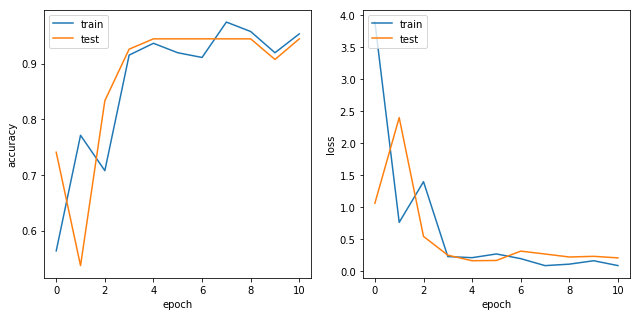

Training score:  1.0  , Testing score: 0.9444444444444444
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[24  3]
 [ 0 27]]
Thinks Anthony is Paul ====== 


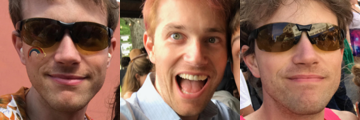

Experiment4/twinmodel5_0.001_100_1e-05.h5 , i:  5 , lr:  0.001  num_dense:  100


/Users/Anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ze..., outputs=Tensor("de...)`


40
Train on 236 samples, validate on 54 samples
Epoch 1/50
236/236 [==============================] - 200s 849ms/step - loss: 5.4307 - acc: 0.4746 - val_loss: 1.7201 - val_acc: 0.6667
Epoch 2/50
236/236 [==============================] - 192s 814ms/step - loss: 0.8547 - acc: 0.8093 - val_loss: 0.5293 - val_acc: 0.8148
Epoch 3/50
236/236 [==============================] - 192s 814ms/step - loss: 0.4272 - acc: 0.8644 - val_loss: 0.3312 - val_acc: 0.8889
Epoch 4/50
236/236 [==============================] - 193s 818ms/step - loss: 0.2855 - acc: 0.8771 - val_loss: 0.2230 - val_acc: 0.9259
Epoch 5/50
236/236 [==============================] - 192s 813ms/step - loss: 0.3353 - acc: 0.9153 - val_loss: 0.1936 - val_acc: 0.9444
Epoch 6/50
236/236 [==============================] - 202s 855ms/step - loss: 0.1747 - acc: 0.9280 - val_loss: 0.2636 - val_acc: 0.9074
Epoch 7/50
236/236 [==============================] - 192s 812ms/step - loss: 0.1119 - acc: 0.9661 - val_loss: 0.2111 - val_acc: 0.9630


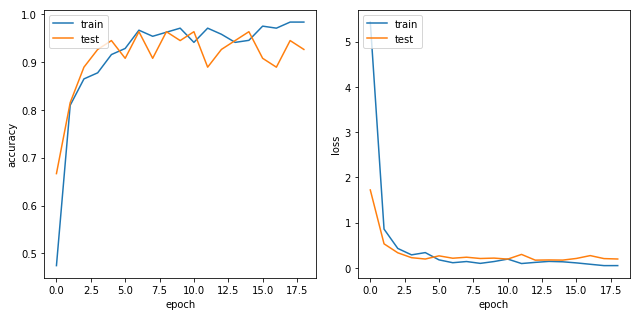

Training score:  1.0  , Testing score: 0.9259259259259259
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[24  3]
 [ 1 26]]
Thinks Paul is Anthony ====== 


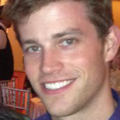

Thinks Anthony is Paul ====== 


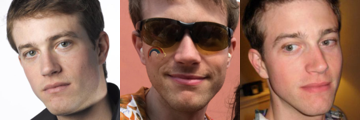

Experiment4/twinmodel5_0.001_100_2e-05.h5 , i:  5 , lr:  0.001  num_dense:  100
40
Train on 236 samples, validate on 54 samples
Epoch 1/50
236/236 [==============================] - 193s 819ms/step - loss: 2.4553 - acc: 0.6525 - val_loss: 0.7490 - val_acc: 0.8333
Epoch 2/50
236/236 [==============================] - 192s 815ms/step - loss: 0.6206 - acc: 0.8051 - val_loss: 0.3995 - val_acc: 0.8704
Epoch 3/50
236/236 [==============================] - 194s 821ms/step - loss: 0.3282 - acc: 0.8898 - val_loss: 0.2401 - val_acc: 0.8519
Epoch 4/50
236/236 [==============================] - 193s 820ms/step - loss: 0.2582 - acc: 0.8771 - val_loss: 0.3191 - val_acc: 0.9259
Epoch 5/50
236/236 [==============================] - 193s 820ms/step - loss: 0.2284 - acc: 0.9364 - val_loss: 0.3773 - val_acc: 0.9259
Epoch 6/50
236/236 [==============================] - 191s 811ms/step - loss: 0.1957 - acc: 0.9195 - val_loss: 0.2378 - val_acc: 0.9074
Epoch 7/50
236/236 [==============================] - 19

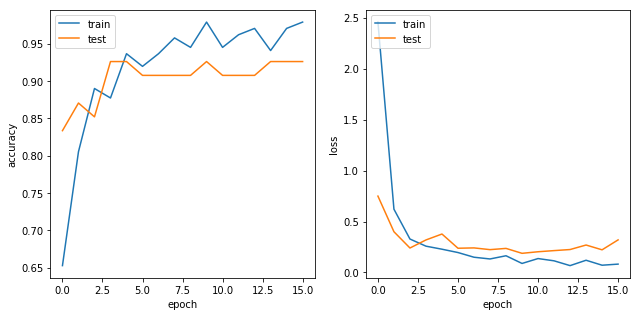

Training score:  0.9957627118644068  , Testing score: 0.9259259259259259
Training  =====================
[[117   1]
 [  0 118]]
Thinks Anthony is Paul ====== 


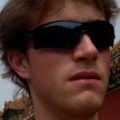

Testing  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


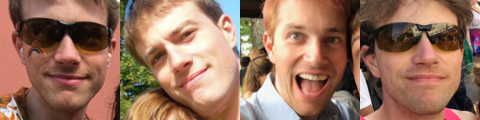

Experiment4/twinmodel5_0.001_100_4e-05.h5 , i:  5 , lr:  0.001  num_dense:  100
40
Train on 236 samples, validate on 54 samples
Epoch 1/50
236/236 [==============================] - 202s 856ms/step - loss: 3.4088 - acc: 0.6102 - val_loss: 1.1241 - val_acc: 0.6481
Epoch 2/50
236/236 [==============================] - 203s 860ms/step - loss: 2.1982 - acc: 0.6864 - val_loss: 0.4412 - val_acc: 0.8889
Epoch 3/50
236/236 [==============================] - 221s 936ms/step - loss: 0.4748 - acc: 0.8263 - val_loss: 0.1786 - val_acc: 0.9074
Epoch 4/50
236/236 [==============================] - 206s 873ms/step - loss: 0.5729 - acc: 0.8263 - val_loss: 0.3570 - val_acc: 0.8889
Epoch 5/50
236/236 [==============================] - 212s 900ms/step - loss: 0.2146 - acc: 0.9364 - val_loss: 0.3924 - val_acc: 0.8889
Epoch 6/50
236/236 [==============================] - 232s 985ms/step - loss: 0.1641 - acc: 0.9322 - val_loss: 0.2611 - val_acc: 0.9259
Epoch 7/50
236/236 [==============================] - 20

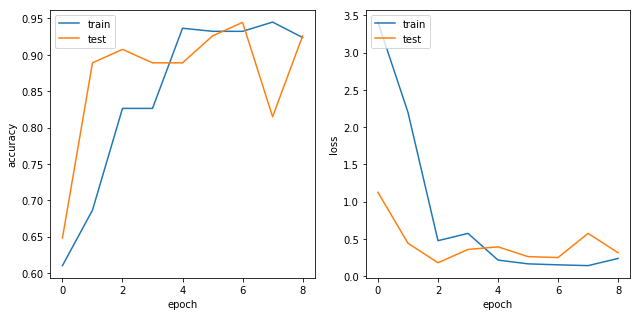

Training score:  1.0  , Testing score: 0.9259259259259259
Training  =====================
[[118   0]
 [  0 118]]
Testing  =====================
[[23  4]
 [ 0 27]]
Thinks Anthony is Paul ====== 


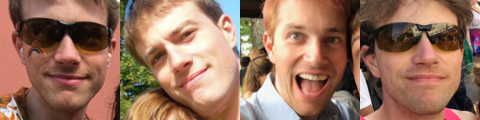

In [11]:
# Further optimize, with patience = 6
early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='auto')
this_folder = 'Experiment4/'
if not os.path.exists(this_folder):
    os.makedirs(this_folder)
for i in [5]:
    for lr in [.001]:
        for num_dense in [100]:
            for decay in [.000005,.00001,.00002,.00004]:
                file_save = this_folder + 'twinmodel' + str(i) + '_' + str(lr) + '_' + str(num_dense)+ '_' + str(decay) + '.h5'
                pckl_save_hist = this_folder + 'twinmodel'+str(i)+ '_' + str(lr) + '_' + str(num_dense)+ '_' + str(decay)+'hist.pckl'
                pckl_save = this_folder + 'twinmodel_pred' + str(i)+ '_' + str(lr) + '_' + str(num_dense)+ '_' + str(decay) + '.pckl'
                print(file_save,', i: ',i,', lr: ',lr,' num_dense: ',num_dense )
                if os.path.isfile(file_save) == False:
                    history = History()
                    model = instantiate_model(i,num_dense=num_dense)
                    #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
                    model.compile(optimizer=keras.optimizers.SGD(lr=lr, momentum=0.0, decay=decay, nesterov=False),
                                  loss='categorical_crossentropy',metrics=['accuracy'])
                    #history = model.fit(trainX, trainY, batch_size=50, epochs=50)  
                    model.fit(trainX, trainY, batch_size=50, epochs=50,
                                        shuffle=True,validation_data=(testX, testY), callbacks=[history,early_stopping])

                    model.save(file_save)        
                    #tmp = open(pckl_save_hist, 'wb')
                    with open(pckl_save_hist, 'wb') as tmp:
                        pickle.dump([history], tmp)
                    #tmp.close()
                else:
                    model = load_model(file_save)
                    #try:
                    #tmp = open(pckl_save_hist, 'rb')
                    #history = pickle.load(tmp)
                    #tmp.close()   
                    with open(pckl_save_hist, 'rb') as tmp:
                        history = pickle.load(tmp)

                if os.path.isfile(pckl_save) == False: 
                    test_predY = model.predict(testX[:])[:,1]
                    train_predY = model.predict(trainX[:])[:,1]
                    #tmp = open(pckl_save, 'wb')
                    with open(pckl_save, 'wb') as tmp:
                        pickle.dump([test_predY,train_predY], tmp)
                    #tmp.close()
                else:
                    #tmp = open(pckl_save, 'rb')
                    with open(pckl_save, 'rb') as tmp:
                        [test_predY,train_predY] = pickle.load(tmp)
                    #tmp.close()  

                try:
                    plot_history(history[0])
                except:
                    plot_history(history)

                test_predY2 = test_predY.round().astype(int)
                testY2 = testY[:,1].round().astype(int)
                train_predY2 = train_predY.round().astype(int)
                trainY2 = trainY[:,1].round().astype(int)
                score_train = accuracy_score(trainY2,train_predY2)
                score_test = accuracy_score(testY2,test_predY2)
                print('Training score: ',score_train, ' , Testing score:',score_test)
                show_errors(train_predY2,trainY2,trainX,'Training')
                show_errors(test_predY2,testY2,testX,'Testing')

In [205]:
# Play around with lime package
from lime import lime_image
import lime
from skimage.segmentation import mark_boundaries

In [257]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(trainX[3], model.predict, top_labels=2, hide_color=0, num_samples=100)


/Users/Anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/Anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


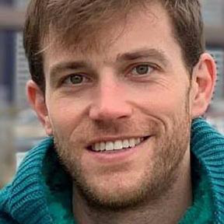

1.0


In [258]:
plot_image(trainX[3])
print(train_predY[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


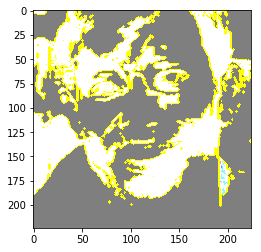

In [259]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=2000, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

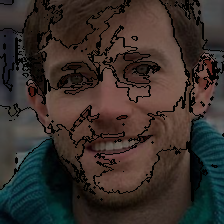

In [260]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=200, hide_rest=False)
plot_image(mark_boundaries(temp / 2 + 0.5, mask))

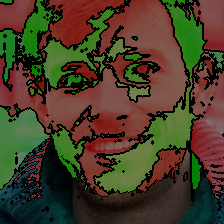

In [261]:
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=1000, hide_rest=False)
plot_image(mark_boundaries(temp / 2 + 0.5, mask))

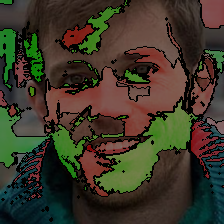

In [262]:
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.05)
plot_image(mark_boundaries(temp / 2 + 0.5, mask))

In [64]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def verifyFace(img1, img2, mod):
    """Compares 2 faces: img1 and img2"""
    #img1_representation = vgg_face_descriptor.predict(preprocess_image('C:/Users/IS96273/Desktop/trainset/%s' % (img1)))[0,:]
    #img2_representation = vgg_face_descriptor.predict(preprocess_image('C:/Users/IS96273/Desktop/trainset/%s' % (img2)))[0,:]
    
    img1_representation = mod.predict(img1)[0,:]
    img2_representation = mod.predict(img2)[0,:]
    
    #print(img1_representation)
    #print(img2_representation)
    print(img1_representation.shape)
    len = img1_representation.shape[0]
    plt.plot(img1_representation,color='r')
    plt.plot(img2_representation,color='b')
    plt.show()
    #print(list(zip(img1_representation,img2_representation)))
    
    cosine_similarity = findCosineDistance(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    #plt.imshow(image.load_img('C:/Users/IS96273/Desktop/trainset/%s' % (img1)))
    plt.imshow(256-np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    #plt.imshow(image.load_img('C:/Users/IS96273/Desktop/trainset/%s' % (img2)))
    plt.imshow(256-np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

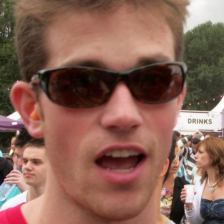

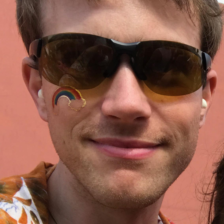

In [87]:
img1 = np.ndarray([1,224,224,3])
img2 = np.ndarray([1,224,224,3])
img1[:,:,:,:] = testX[14,:,:,:]
img2[:,:,:,:] = testX[30,:,:,:]
plot_image(np.squeeze(img1))
plot_image(np.squeeze(img2))

In [ ]:
epsilon = 0.40
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

(100,)


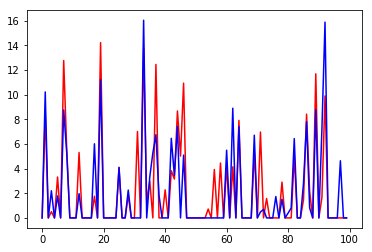

Cosine similarity:  0.13973468542099
Euclidean distance:  21.714138
verified... they are same person


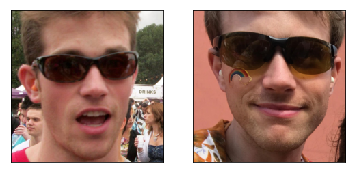

-----------------------------------------


In [88]:
verifyFace(img1,img2,vgg_face_descriptor)

In [95]:
model.get_layer

<bound method Network.get_layer of <keras.engine.training.Model object at 0x1c44165fd0>>